In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker

import geopandas as gpd
import earthpy as et

import requests as rq

from header import AWhereAPI
from secret_codes import *

In [2]:
# Import codes from secret_codes.py
api_key = API_KEY
api_secret = API_SECRET

In [3]:
# Create aWhere object
aw = AWhereAPI(api_key, api_secret)

# To get auth token, encode secret and key
sc = aw.encode_secret_and_key(API_KEY, API_SECRET)

# Then call auth token
token = aw.get_oauth_token(sc)

# Set up headers: auth and specific header for agronomics data
auth_headers = {"Authorization": "Bearer %s" % token,
                "Content-Type": 'application/json'}

agro_header = {"Authorization":  "Bearer %s" % token}

# General aWhere API endpoint "prefix"
endpt = "https://api.awhere.com"

In [4]:
# Function to fetch agronomic norms json
# given lat, long, start, end day ("day" can include year)


def agro_json(start_day, end_day, latitude, longitude, search_type, properties=None):
    """
    Reads in temporal and spatial info and returns JSON-like object from aWhere's API. 
    Additional param allows user to enter specific search parameters as a string.

    Parameters
    ----------
    start_day, end_day: string
        Formatted as MM-DD for historical averages
        or YYYY-MM-DD for specific date range

    longitude, latitude: string, int, or float
        Decimal degrees location of centroid of
        9 sq km grid to get agronomic info for

    search_type: string
        Accepts "norms" for historical norms
        or "values" for specific date range

    properties: string (optional)
        User-defined string with optional additional 
        search parameters

    Returns
    -------
    ag_json: JSON-like object
        Contains response from aWhere's agronomics API.
    """

    if properties:

        hist_ag_url = f"/v2/agronomics/locations/{latitude},{longitude}/agronomic{search_type}/{start_day},{end_day}{properties}"

    else:

        hist_ag_url = f"/v2/agronomics/locations/{latitude},{longitude}/agronomic{search_type}/{start_day},{end_day}"

    # Get JSON from API
    ag_json = rq.get((endpt + hist_ag_url), headers=agro_header).json()

    return ag_json

In [5]:
def json_package(latitude, longitude, start, end, search_type, pages):
    
    """
    Reads in spatial and temporal info and returns a list of JSONS
    since aWhere's results are limited to 10 per page. To make more
    useful, function could auto-calculate number of pages.
    
    Parameters
    ----------
    longitude, latitude: string, int, or float
        Decimal degrees location of centroid of
        9 sq km grid to get agronomic info for
        
    start, end: string
        Formatted as MM-DD for historical averages
        or YYYY-MM-DD for specific date range

    search_type: string
        Accepts "norms" for historical norms
        or "values" for specific date range

    pages: str, int
        Number of pages that API call will return
        at 10 results per page
    
    """
    
    # Holds all JSONs returned from API call
    json_list = []
    
    # Must do pages + 1 to include last page in offset calc
    for page in range(0, pages+1):

        offset = (page * 10)

        # Get json
        period_json = agro_json(start, end, latitude, longitude, f"{search_type}",
                                f"?limit=10&offset={offset}")

        # Add json to list of JSONs
        json_list.append(period_json)

    return json_list

In [6]:
# Get list of jsons for April norms
# TODO: I know there are 3 pages but
# function should auto-calculate this

april_norms = json_package(latitude=41.726667,
                           longitude=-122.6375,
                           start="04-01",
                           end="04-30",
                           search_type="norms",
                           pages=3)

In [7]:
# Get df containing April norms
master_list = []

for period_json in april_norms:

    # For each day in all days in json
    for day in range(0, len(period_json['dailyNorms'])):

        # List to hold values from specific day
        day_list = []

        # Add date
        day_list.append(period_json['dailyNorms'][day].get('day'))

        # Add average ppet
        day_list.append(period_json['dailyNorms']
                        [day].get('ppet').get('average'))

        # Add ppet stddev
        day_list.append(period_json['dailyNorms']
                        [day].get('ppet').get("stdDev"))

        # Add accumulated ppet average
        day_list.append(period_json['dailyNorms'][day].get(
            'accumulatedPpet').get('average'))

        # Add accumulated ppet stddev
        day_list.append(period_json['dailyNorms'][day].get(
            'accumulatedPpet').get('stdDev'))

        # Add list to "list of lists"
        master_list.append(day_list)

# Convert master list to dataframe
ppet_april_norms = pd.DataFrame(master_list, columns=['day', 'ppet_avg', 'ppet_std',
                                                      'accumulated_ppet_avg', 'accumulated_ppet_std'])

# Get day number
ppet_april_norms['day_num'] = ppet_april_norms['day'].str[3:5]

# Cast day_num to int
ppet_april_norms['day_num'] = ppet_april_norms['day_num'].astype('int')

In [8]:
# Get list of JSONs for this April (2020)
# TODO: I know there are 3 pages but
# function should auto-calculate this

april_values = json_package(latitude=41.726667,
                            longitude=-122.6375,
                            start="2020-04-01",
                            end="2020-04-30",
                            search_type="values",
                            pages=3)

In [9]:
# Get df for this April (2020)
master_list = []

for period_json in april_values:

    # For each day in all days in json
    for day in range(0, len(period_json['dailyValues'])):

        # List to hold values from specific day
        day_list = []

        day_list.append(period_json['dailyValues'][day].get('date'))

        # Get daily ppet
        day_list.append(period_json['dailyValues'][day].get('ppet'))

        # Get accumulated ppet
        day_list.append(period_json['dailyValues'][day].get('accumulatedPpet'))

        master_list.append(day_list)

ppet_april_2020 = pd.DataFrame(
    master_list, columns=['day', 'daily_ppet', 'accumulated_ppet'])

# Change 'day' to datetime
ppet_april_2020['day'] = pd.to_datetime(ppet_april_2020.day)

# Set 'day' as index
ppet_april_2020.set_index('day', inplace=True)

# Create "day_num" column for graphing
ppet_april_2020['day_num'] = ppet_april_2020.index.day

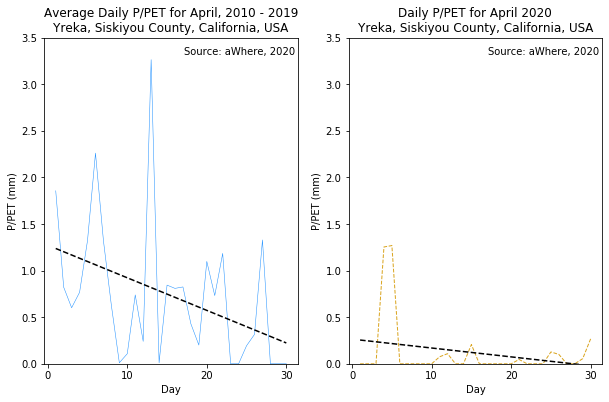

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

# Set x-axis tick for both plots
tic = plticker.MultipleLocator(base=10)

"""Plot 1: April Norms"""

# Set labels and title
ax1.set(title="Average Daily P/PET for April, 2010 - 2019\n" +
        "Yreka, Siskiyou County, California, USA",
        xlabel="Day",
        ylabel="P/PET (mm)")

# Create plot of average P/PET
ax1.plot(ppet_april_norms.day_num, ppet_april_norms.ppet_avg,
         label="Daily Average P/PET, April (mm)",
         linewidth=0.5,
         color='dodgerblue')

# Set ticker at regular intervals
ax1.xaxis.set_major_locator(tic)

# Plots have same scale
ax1.set_ylim((0, 3.5))

# Add best fit line
z = np.polyfit(ppet_april_norms.day_num, ppet_april_norms.ppet_avg, 1)
p = np.poly1d(z)
ax1.plot(ppet_april_norms.day_num, p(ppet_april_norms.day_num),
         color='black',
         linestyle="--")

# Add source info
ax1.text(0.55, 0.95, transform=ax1.transAxes, s="Source: aWhere, 2020")


"""Plot 2: This April (2020)"""

# Set labels and title
ax2.set(title="Daily P/PET for April 2020\n" +
        "Yreka, Siskiyou County, California, USA",
        xlabel="Day",
        ylabel="P/PET (mm)")

# Create plot of average P/PET
ax2.plot(ppet_april_2020.day_num, ppet_april_2020.daily_ppet,
         label="P/PET",
         linewidth=1,
         color='goldenrod',
         linestyle='--')

# Set ticker at regular intervals
ax2.xaxis.set_major_locator(tic)

# Plots have same scale
ax2.set_ylim((0, 3.5))

# Add best fit line
z = np.polyfit(ppet_april_2020.day_num, ppet_april_2020.daily_ppet, 1)
p = np.poly1d(z)
ax2.plot(ppet_april_2020.day_num, p(ppet_april_2020.day_num),
         color='black',
         linestyle="--")

# Add source info
ax2.text(0.55, 0.95, transform=ax2.transAxes,
         s="Source: aWhere, 2020")

# Create export path
fig_3_path = os.path.join(et.io.HOME, "desktop",
                          "drought", "data", "images", "fig_3.png")

# Save figure
plt.savefig(fig_3_path, bbox_inches="tight")

plt.show()

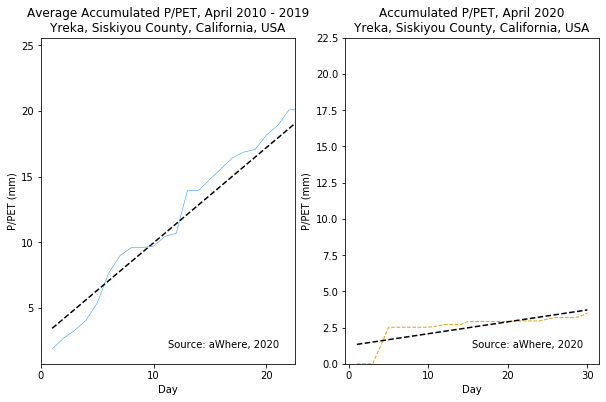

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

# Set x-axis tick for both plots
tic = plticker.MultipleLocator(base=10)

"""Plot 1: Historic Values (April)"""

# Set labels and title
ax1.set(title="Average Accumulated P/PET, April 2010 - 2019\n" +
        "Yreka, Siskiyou County, California, USA",
        xlabel="Day",
        ylabel="P/PET (mm)")

# Create plot of average accumulated ppet
ax1.plot(ppet_april_norms.day_num, ppet_april_norms.accumulated_ppet_avg,
         label="Average accumulated P/PET (mm)", linewidth=0.5, color='dodgerblue')

# Set ticker at regular intervals
ax1.xaxis.set_major_locator(tic)

# Set plots to be same size
ax1.set_xlim((0, 22.5))

# Add best fit line
z = np.polyfit(ppet_april_norms.day_num,
               ppet_april_norms.accumulated_ppet_avg, 1)
p = np.poly1d(z)
ax1.plot(ppet_april_2020.day_num, p(ppet_april_2020.day_num),
         color='black',
         linestyle="--")

# Add source info
ax1.text(0.5, 0.05, transform=ax1.transAxes, s="Source: aWhere, 2020")

"""Plot 2: This April"""
# Set labels and title
ax2.set(title="Accumulated P/PET, April 2020\n" +
        "Yreka, Siskiyou County, California, USA",
        xlabel="Day",
        ylabel="P/PET (mm)")

# Create plot of accumulated P/PET
ax2.plot(ppet_april_2020.day_num, ppet_april_2020.accumulated_ppet,
         label="Accumulated P/PET (mm)",
         linewidth=1,
         color='goldenrod',
         linestyle='--')

# Set ticker at regular intervals
ax2.xaxis.set_major_locator(tic)

# Scale same as plot 1
ax2.set_ylim((0, 22.5))

# Add best fit line
z = np.polyfit(ppet_april_2020.day_num,
               ppet_april_2020.accumulated_ppet, 1)
p = np.poly1d(z)
ax2.plot(ppet_april_2020.day_num, p(ppet_april_2020.day_num),
         color='black',
         linestyle="--")

# Add source info
ax2.text(0.5, 0.05, transform=ax2.transAxes, s="Source: aWhere, 2020")

# Create export path
fig_4_path = os.path.join(et.io.HOME, "desktop",
                          "drought", "data", "images", "fig_4.png")

# Save figure
plt.savefig(fig_4_path, bbox_inches="tight")

plt.show()